# University of Exeter
## College of Engineering, Mathematics and Physical  Sciences
### ECM3420 - Learning From Data

#### Coursework 2 - Clutering

### Enter your candidate number here:

## Task 1

In [5]:
import numpy as np
from math import sqrt

class Centroid:
    """Data structure for holding a Centroid.

    Initialise with a unique label and a numpy array as a value. 

    Attributes:
        label: The label assigned to the centroid. 
        initial_value: Numpy array representing the centroid of all data points associated with this centroid
    """


    def __init__(self, label, initial_value):
        self.value = initial_value
        self.label = label
    

    def __str__(self):
        return f"Centroid({self.label} of value {self.value})"


    def calculate_value(self, data_points):
        """Calculate the value of a centroid based on all datapoints.

        Loops through all data points to find ones associated with current centroid.
        Finds and sets the average centroid based on assigned data points.

        Args:
            data_points: List of all data points being analysed
        
        Returns:
            Numpy array representing the new value of a centroid
        """
        # Initialise new value with same dimensions as current
        new_value = np.zeros_like(self.value)

        data_point_count = 0

        # Sum all datapoints
        for data_point in data_points:
    
            if data_point.centroid is self:
                new_value += data_point.value
                data_point_count += 1

        # Average new value by number of datapoints
        new_value /= data_point_count

        self.value = new_value

        return new_value


class DataPoint:
    """Data structure for a datapoint with a centroid association.

    Attributes:
        value: Numpy array holding the datapoint's value
        centroid: Centroid instance representing the datapoint's currently associated centroid
    """

    def __init__(self, value):
        self.value = value
        self.centroid = None


    def __str__(self):
        return f"DataPoint({self.value} of centroid {self.centroid})"


    def assign_to_nearest_centroid(self, centroids):
        """Assigns the datapoint to its nearest centroid from a list of given centroids.

        Args:
            centroids: List of centroids

        Returns:
            (old_centroid, new_centroid)
                old_centroid: The previous centroid associated with the value. Note that for the initial iteration, this will be None
                new_centroid: The newly assigned centroid. Note that as centroids converge, this could be the same as old_centroid
        """
        flag_first = True
        
        min_distance = 0
        min_centroid = None

        old_centroid = self.centroid

        for centroid in centroids:
            distance = euclidian_distance(self.value, centroid.value)
            # Initialise minimum value
            if flag_first:
                flag_first = False
                min_distance = distance
                min_centroid = centroid
                pass
            
            # Update minimum distance and centroid
            if distance < min_distance:
                min_distance = distance
                min_centroid = centroid
        
        self.centroid = min_centroid
        
        return old_centroid, self.centroid

# ------------------------------------ #
#                 UTILS                #
# ------------------------------------ #
def euclidian_distance(point1, point2):
    """Calculate the euclidian distance between two points.

    Args:
        point1: Numpy array representing the first point
        point2: Numpy array representing the second point
    
    Returns:
        Float value of the euclidian distance between point1 and point2
    """
    return sqrt(sum(np.square(point2 - point1)))


def initialise(x, k):
    """Initialise DataPoints and Centroids for K-Means-Clustering

    Create a list of DataPoint objects based on the points in x. 
    Initialise k Clusters, each with a random point as a starting value.
    
    Args:
        x: A list of datapoints
        k: The number of centroids to initialise
    
    Returns:
        centroids: A list of initialised Centroids
        data_points: A list of initialised DataPoints
    """
    # Create a DataPoint instance for each datapoint in x then form a list of these
    data_points = [DataPoint(dp) for dp in x]

    # Randomly choose k points to initialise as clusters
    random_points_indices = np.random.choice(len(data_points), size=k)
    
    # Fetch the DataPoint instances that correspond to the random indices
    initial_centroid_points = [data_points[index] for index in random_points_indices]

    # Create a list of centroids initialised with the DataPoint values above. Assign a unique label to each
    centroids = [Centroid(label=i, initial_value=c.value) for i, c in enumerate(initial_centroid_points)]

    return centroids, data_points    


def incremental_kmeans(x, k, y=None, max_itr=100, random_state=None):
    """Run incremental K-Means Clustering on a dataset

    Runs incremental K-Means Clustering on a dataset. Returns a list of datapoint cluster labels 
    and the number of iterations taken. 

    Args:
        x: A list consisting of numpy arrays as datapoints
        k: The number of clusters to find
        max_itr: The maximum number of iterations to run before ending iteration. Default=100
        random_state: Integer value used to seed the randomness for deterministic behaviour. Default=None
        y: A list consisting of test data. Labels will be determined and returned.
    Returns:
        cluster_labels: A list consisting of each datapoint's cluster association
        iter_count: The number of iterations the K-Means Clustering ran.
        If y is given:
            y_labels: A list consisting of each test datapoint's cluster association
    """
    # Seed the randomness if a value is provided.
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialise centroids and data points from x and k
    centroids, data_points = initialise(x, k)

    # Initial iteration, assigning points to their initial centroids
    for point in data_points:
        point.assign_to_nearest_centroid(centroids)

    
    flag_stop = False
    iter_count = 0

    while not flag_stop:
        iter_count += 1
        flag_stop = True

        for point in data_points:
            # Retrieve the old and new centroid assignments for the current point
            old_centroid, new_centroid = point.assign_to_nearest_centroid(centroids)    
            
            # In the first iteration, a point will not have an old centroid so we need this check
            if old_centroid is not None:
                old_centroid.calculate_value(data_points)

            new_centroid.calculate_value(data_points)

            # A centroid has changed so we should continue iterating
            if old_centroid is not new_centroid:
                flag_stop = False

        if iter_count == max_itr:
            print("Ended having reached maximum iterations")
            flag_stop = True
    
    cluster_labels = [data_point.centroid.label for data_point in data_points]

    if y is not None:
        y_data_points = [DataPoint(dp) for dp in y]

        for data_point in y_data_points:
            data_point.assign_to_nearest_centroid(centroids)
        
        y_cluster_labels = [data_point.centroid.label for data_point in y_data_points]

        return cluster_labels, iter_count, y_cluster_labels
        
    return cluster_labels, iter_count

## Task 2

In [8]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import time

dataset = load_iris().data

inc_times = {2: [], 3: [], 4: [], 5: []}
inc_iters = {2: [], 3: [], 4: [], 5: []}

std_times = {2: [], 3: [], 4: [], 5: []}
std_iters = {2: [], 3: [], 4: [], 5: []}

# Where we are just evaluating speed / performance here, there is no point
# splitting the data into training and testing data. 
for m in range(5):
    for k in range(2, 6):
        time_start = time.time()
        iters = incremental_kmeans(dataset, k)[1]
        time_end = time.time()
        
        inc_times[k].append(time_end-time_start)
        inc_iters[k].append(iters)

        time_start = time.time()
        kmeans = KMeans(n_clusters=k).fit(dataset)
        time_end = time.time()

        std_times[k].append(time_end-time_start)
        std_iters[k].append(kmeans.n_iter_)

       


In [11]:
from tabulate import tabulate
from IPython.display import HTML, display


def avg_results(results):
    """Convert a list of lists to a list of averages.

    Converts a list of lists to a list of averages. Each inner list is reduced down to
    its average and added to the return list at the corresponding position.

    Args:
        results: A list of lists, each list containing numbers
    
    Returns:
        The list of averages
    """
    averages = [(sum(row)/len(row)) for row in results.values()]
    return averages


def format_table(time1, iter1, time2, iter2):
    """Formats time and iteration values into rows for the tabulate module.

    Args:
        time1: The results from testing Incremental K-Means runtime
        iter1: The results from testing Incremental K-Means Iteration counts
        time2: The results from testing Standard K-Means runtime
        iter2: The results from testing Standard K-Means Iteration counts

    Returns:
        A list of rows that the tabulate function will accept
    """
    row1 = ["", "", "K=2", "K=3", "K=4", "K=5"]
    row2 = ["Inc K-Means", "Average Time"] + avg_results(time1)
    row3 = ["", "Average Iterations"] + avg_results(iter1)
    
    row4 = ["Std K-Means", "Average Time"] + avg_results(time2)
    row5 = ["", "Average Iterations"] + avg_results(iter2)
    return [row1, row2, row3, row4, row5]

# Display the results formatted above in HTML
display(HTML(tabulate(format_table(inc_times, inc_iters, std_times, std_iters), tablefmt="html")))

,,K=2,K=3,K=4,K=5
Inc K-Means,Average Time,0.05753812789916992,0.07320933341979981,0.10400562286376953,0.06240224838256836
,Average Iterations,2.4,3.8,6.4,4.0
Std K-Means,Average Time,0.011199283599853515,0.017791271209716797,0.02000293731689453,0.02099018096923828
,Average Iterations,3.2,4.8,4.4,6.4


{'whiskers': [<matplotlib.lines.Line2D at 0x20ded1aacd0>,
 'caps': [<matplotlib.lines.Line2D at 0x20ded1ba3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20ded1aa970>,
 'medians': [<matplotlib.lines.Line2D at 0x20ded1baa90>,
 'fliers': [<matplotlib.lines.Line2D at 0x20ded1badf0>,
 'means': []}

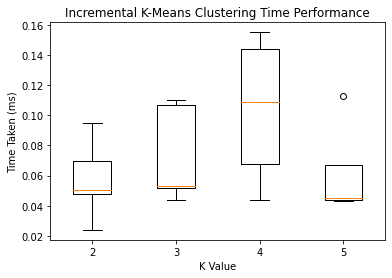

In [14]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.set_title("Incremental K-Means Clustering Time Performance")
ax.set_xlabel("K Value")
ax.set_ylabel("Time Taken (ms)")
ax.boxplot(inc_times.values(), positions=list(inc_times.keys()))

## Task 3

In [ ]:
def jaccard_score_cw2(y_true, y_pred):
    """Calculate the jaccard score for a set of true versus predicted labels

    Args:
        y_true: The list of true labels for each datapoint
        y_pred: The list of labels predicted by a model

    Returns:
        The jaccard score of the predicted labels
    """
    a = b = 0

    for i in range(len(y_true)):

        for j in range(i+1, len(y_true)): 
            # If it is SS, add to a        
            if y_true[i] == y_true[j] and y_pred[i] == y_pred[j]:
                a += 1
            # Else, if it is not DD, add it to the denominator
            elif not(y_true[i] != y_true[j] and y_pred[i] != y_pred[j]):
                b += 1    

    return a/(a+b)

## Task 4

In [75]:
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

iris_data = load_iris()

# Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, train_size=0.7, random_state=2)

# Run incremental method with training data to get predicted y labels
incremental_labels = incremental_kmeans(x=X_train, k=3, y=X_test)[2]

# Train KMeans on training data, then predict test labels
kmeans = KMeans(n_clusters=3).fit(X_train)
standard_labels = kmeans.predict(X_test)


print(jaccard_score_cw2(y_test, incremental_labels))
print(jaccard_score_cw2(y_test, standard_labels))

print(jaccard_score(y_test, incremental_labels, average='weighted'))
print(jaccard_score(y_test, standard_labels, average='weighted'))



0.8492753623188406
0.7412398921832885
0.4015873015873016
0.03209876543209877
